In [1]:
%load_ext autoreload 
%autoreload 2

import os

basepath='/media/data/datasets/sign/rwth-boston-104'
basepath='/data/datasets/rwth-boston-104'
basepath='/home/facundo/datasets/rwth-boston-104'

import numpy as np
import tensorflow as tf
from keras import backend as K
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))
###################################


/home/facundo/.python/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [28]:
import boston104

body_parts=['head','right_hand','left_hand']

localization_grid_shape=(12,16)
localization_target=boston104.LocalizationTargetGrid(localization_grid_shape,body_parts)

# max_distance=20
# localization_target=boston104.LocalizationTargetRegression(max_distance,body_parts)

print("Loading train dataset..")
video_positions_filepath=os.path.join(basepath,'handpositions/train.xml')
batch_size=32
# implement iterator like https://github.com/fizyr/keras-retinanet/blob/master/keras_retinanet/preprocessing/pascal_voc.py
iterator=boston104.Boston104LocalizationIterator(basepath,video_positions_filepath,localization_target,batch_size=batch_size,shuffle=True)

print("Loading test dataset..")
test_video_positions_filepath=os.path.join(basepath,'handpositions/test.xml')
# implement iterator like https://github.com/fizyr/keras-retinanet/blob/master/keras_retinanet/preprocessing/pascal_voc.py
test_iterator=boston104.Boston104LocalizationIterator(basepath,test_video_positions_filepath,localization_target,batch_size=batch_size,shuffle=True)

input_shape=(iterator.h,iterator.w,1)
classes = localization_target.dims()
print("Input shape %s" % str(input_shape))
print("Classes %s" % str(classes))


Loading train dataset..
Loaded 12422 frames. 
After filtering out of bounds positions, we have 11137 frames remaining. 
Loading test dataset..
Loaded 3324 frames. 
After filtering out of bounds positions, we have 3320 frames remaining. 
Input shape (240, 316, 1)
Classes 576


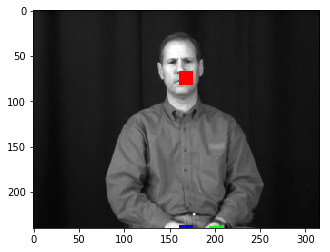

In [20]:
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'

import matplotlib.patches as patches
import utils

def draw_coordinates(image_index,body_parts_coordinates_true,body_parts_coordinates_predicted=None,ax=plt.gca()):
    #image_index=0
    body_parts_colors_true={'head':'#ff0000','left_hand':'#00ff00','right_hand':'#0000ff'}     
    body_parts_colors_predicted={'head':'#550000','left_hand':'#005500','right_hand':'#000055'}     
    for bp in body_parts_coordinates_true.keys():
            true_coordinates=body_parts_coordinates_true[bp]
            draw_square(true_coordinates[image_index,:],color=body_parts_colors_true[bp],ax=ax)
            if (body_parts_coordinates_predicted):
                coordinates=body_parts_coordinates_predicted[bp]
                draw_square(coordinates[image_index,:],color=body_parts_colors_predicted[bp],ax=ax)
    
def draw_square(position,size=15,color='#eeefff',center=False,ax=plt.gca()):
    
    size_x,size_y=(size,size)
    if center:
        position_reversed=(position[1]-size_y/2,position[0]-size_x/2)
    else:
        position_reversed=(position[1],position[0])
    rectangle=patches.Rectangle(position_reversed, size_x,size_y, fill=True,color=color)
    ax.add_patch(rectangle)

#iterator.image_position_to_grid_position(np.array([12,16]),np.array([240,316]),np.array([239,315]))
    
batch_x,batch_y=iterator.next()
# print(batch_y)
body_parts_coordinates=localization_target.predictions_to_body_parts_coordinates(batch_y,input_shape[0:2])

true_coordinates=localization_target.predictions_to_body_parts_coordinates(batch_y,input_shape[0:2])

image_index=0
# print(true_coordinates[image_index,:])
# print(body_parts_coordinates[body_parts[0]][image_index,:])
image=np.copy(batch_x[image_index,:,:,0])
# utils.draw_positions(image,{'head':true_coordinates[image_index,:].astype(int)})
plt.imshow(image)
draw_coordinates(image_index,true_coordinates)

plt.show()


In [29]:
import models

#model=models.resnext(input_shape,classes)
model=models.simple_conv(input_shape,classes)
#model=models.conv_mask(input_shape,classes)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_150 (Conv2D)          (None, 240, 316, 32)      320       
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 120, 158, 32)      9248      
_________________________________________________________________
batch_normalization_134 (Bat (None, 120, 158, 32)      128       
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 120, 158, 32)      9248      
_________________________________________________________________
batch_normalization_135 (Bat (None, 120, 158, 32)      128       
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 60, 79, 32)        9248      
_________________________________________________________________
batch_normalization_136 (Bat (None, 60, 79, 32)        128       
__________

In [30]:
from keras import optimizers

optimizer='rmsprop'
#optimizer= optimizers.SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer,
              loss=localization_target.loss,#'categorical_crossentropy',
              metrics=[localization_target.metric])

history=model.fit_generator(iterator,steps_per_epoch=100, epochs=10)



Epoch 1/10
100/100 [==============================] - 13s 129ms/step - loss: 3.4590 - metric: 0.2169
Epoch 2/10
100/100 [==============================] - 11s 109ms/step - loss: 3.0318 - metric: 0.4210
Epoch 3/10
100/100 [==============================] - 11s 110ms/step - loss: 2.9600 - metric: 0.5598
Epoch 4/10
100/100 [==============================] - 11s 109ms/step - loss: 2.9286 - metric: 0.6308
Epoch 5/10
100/100 [==============================] - 11s 110ms/step - loss: 2.9090 - metric: 0.6889
Epoch 6/10
100/100 [==============================] - 11s 110ms/step - loss: 2.8955 - metric: 0.7178
Epoch 7/10
100/100 [==============================] - 11s 109ms/step - loss: 2.8932 - metric: 0.7413
Epoch 8/10
100/100 [==============================] - 11s 110ms/step - loss: 2.8750 - metric: 0.7835
Epoch 9/10
100/100 [==============================] - 11s 110ms/step - loss: 2.8704 - metric: 0.7908
Epoch 10/10
100/100 [==============================] - 11s 110ms/step - loss: 2.8699 - metr

In [50]:
print(model.metrics_names)

iterator.reset()
test_iterator.reset()
print("train loss, accuracy", model.evaluate_generator(iterator,steps=iterator.n//iterator.batch_size+1))
print("test loss, accuracy", model.evaluate_generator(test_iterator,steps=test_iterator.n//test_iterator.batch_size+1))


['loss', 'metric']
[2.8857820002343568, 0.77743858931746868]
[2.9049595292792261, 0.62228917946298434]
[2.8857819884600713, 0.7774385882310233]
[2.9049595252577083, 0.62228917659047134]


In [ ]:
xb,yb=iterator.next()
predictions = model.predict(xb, batch_size=batch_size)

    

body_parts_coordinates=localization_target.predictions_to_body_parts_coordinates(predictions,input_shape[0:2])
body_parts_true_coordinates=localization_target.predictions_to_body_parts_coordinates(yb,input_shape[0:2])
for bp in localization_grid_target.body_parts:
    print("Body part: %s" % bp)
    true_coordinates=body_parts_true_coordinates[bp]
    coordinates=body_parts_coordinates[bp]
    print(coordinates[:18:2,:].T)
# print(yb)


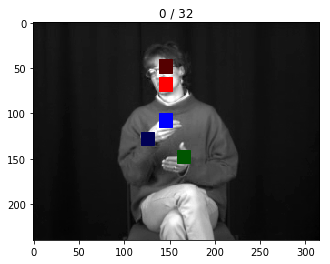

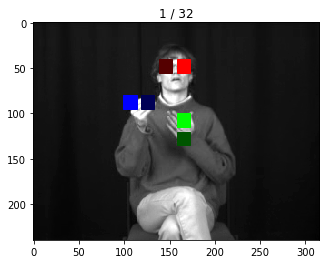

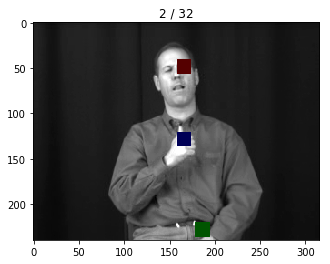

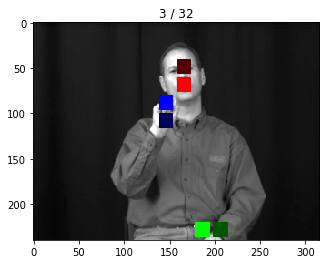

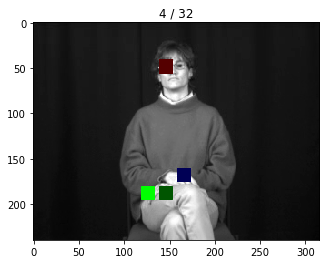

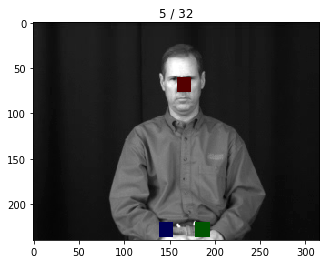

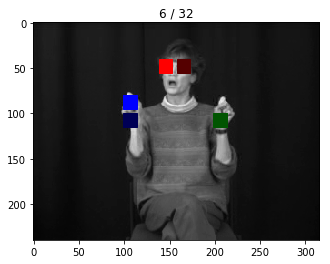

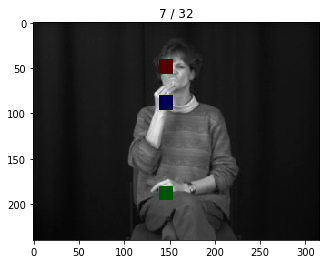

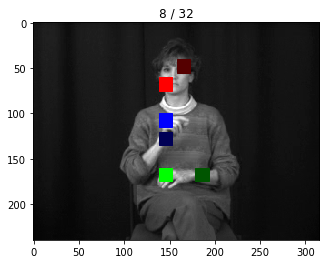

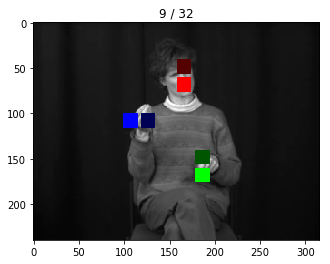

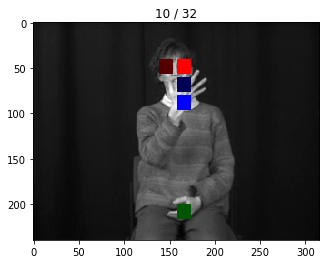

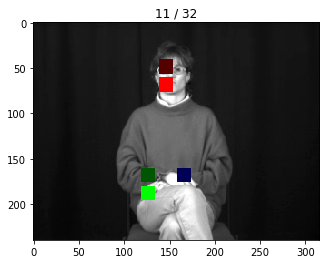

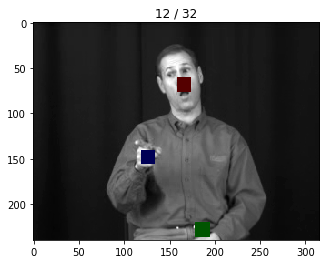

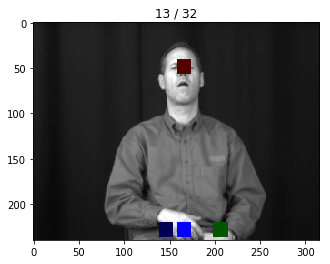

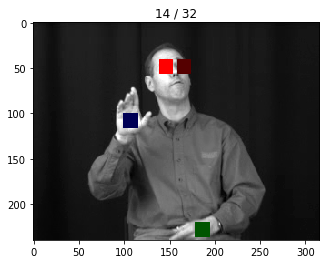

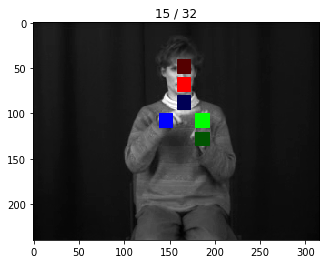

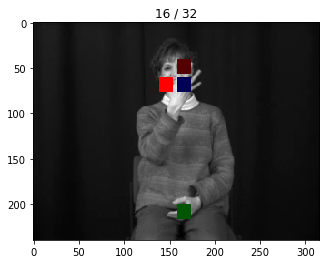

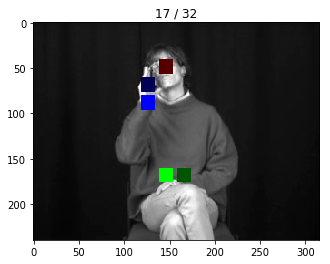

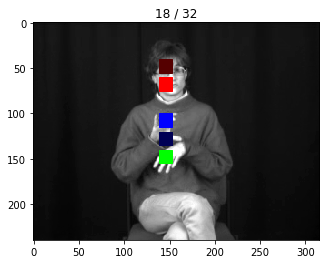

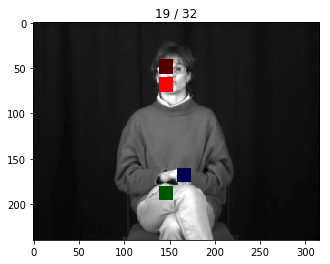

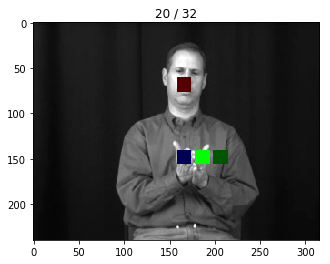

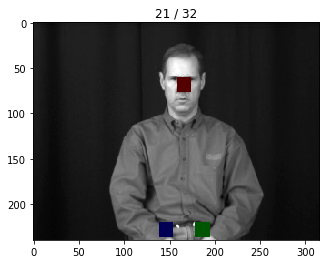

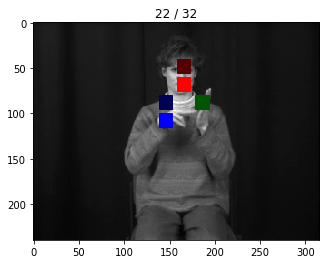

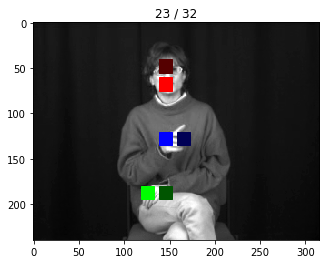

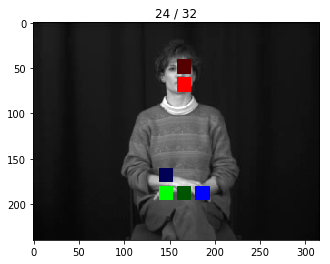

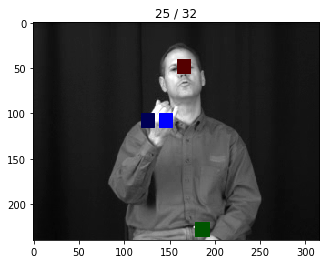

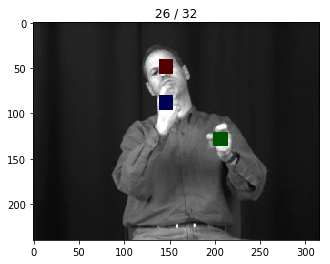

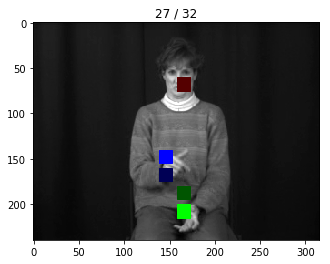

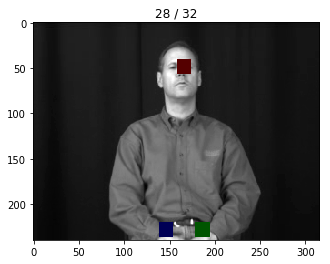

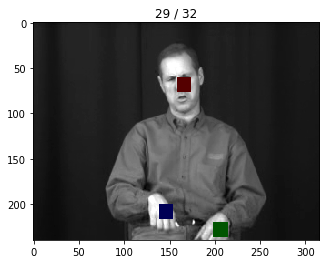

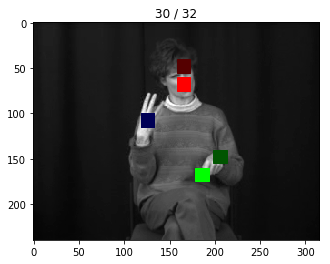

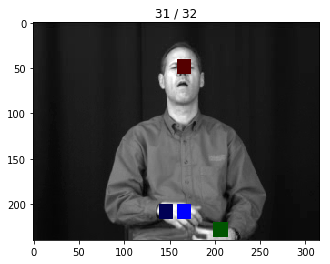

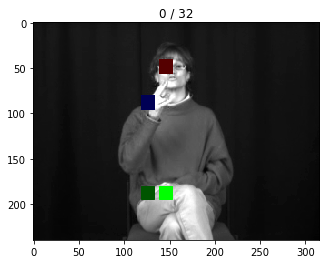

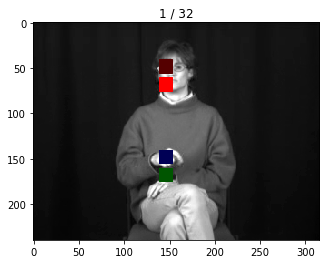

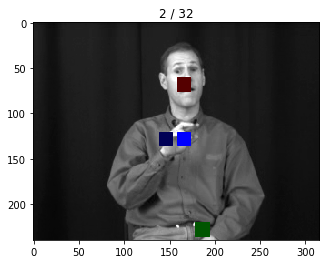

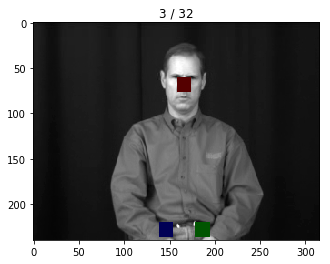

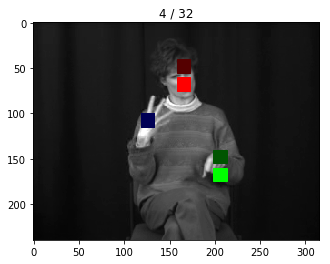

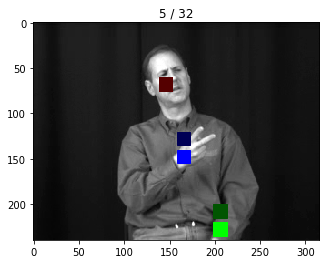

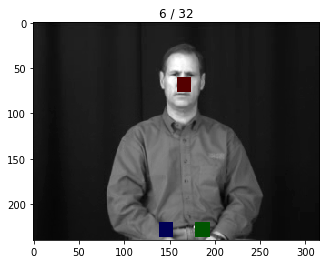

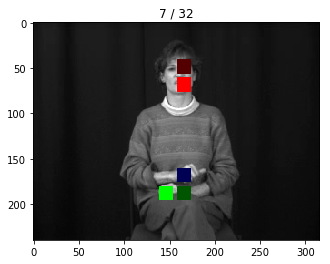

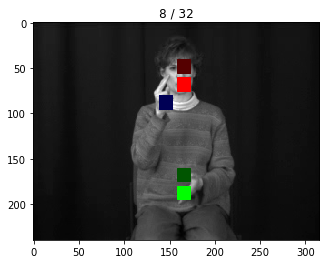

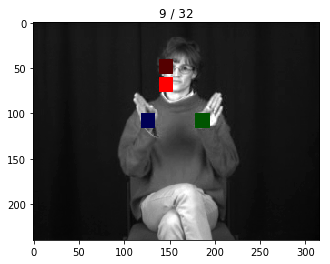

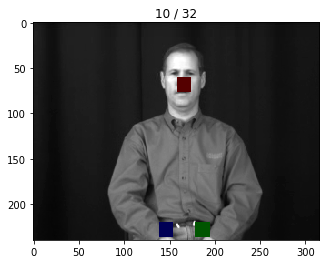

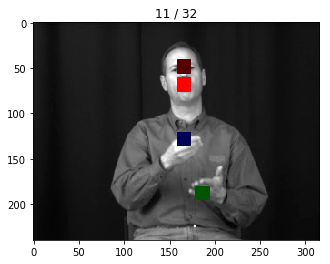

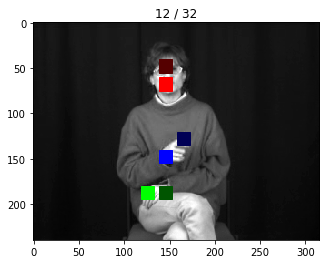

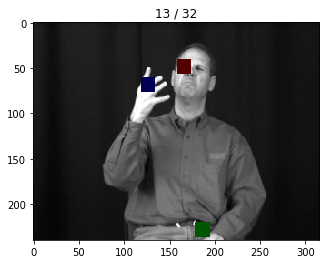

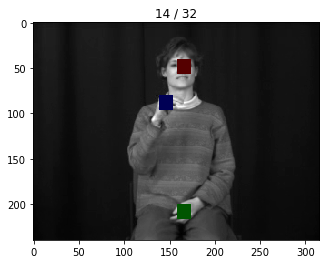

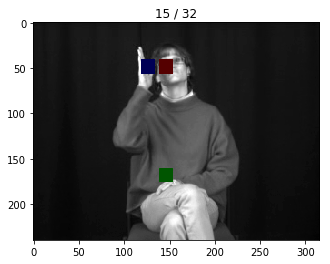

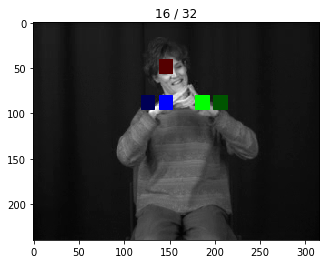

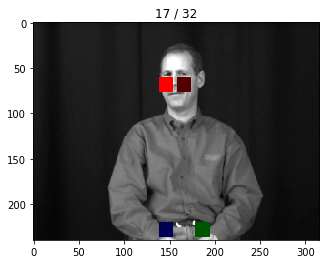

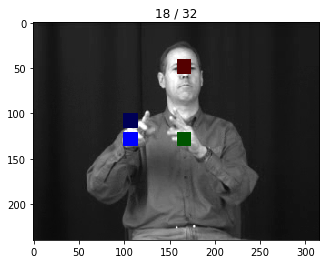

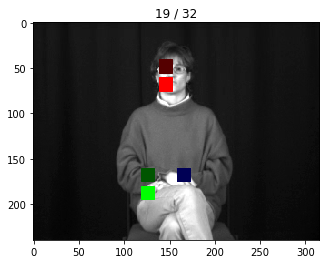

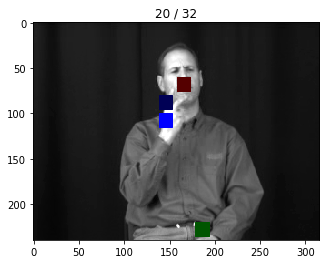

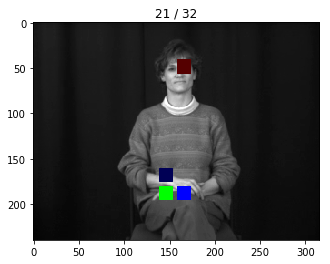

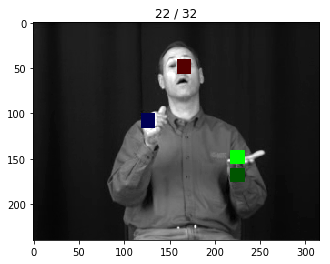

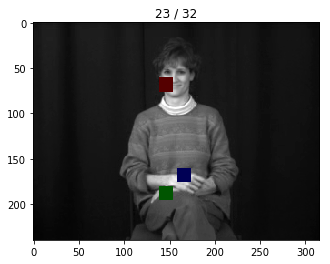

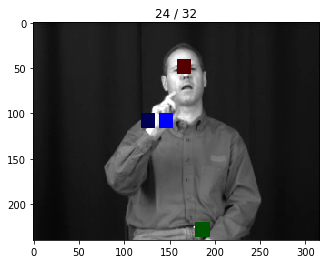

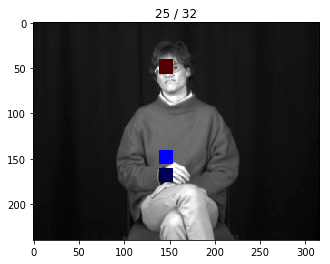

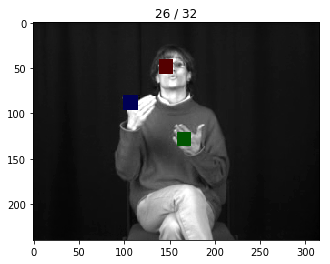

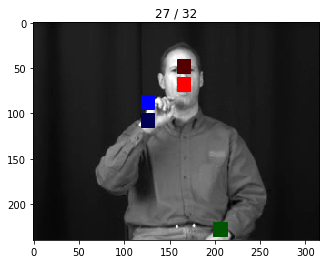

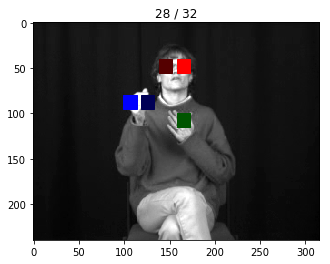

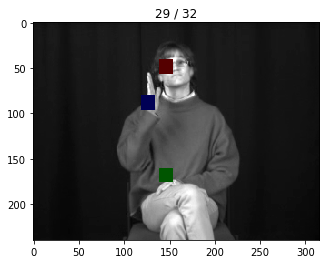

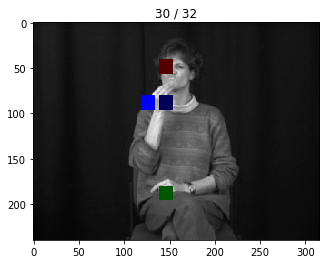

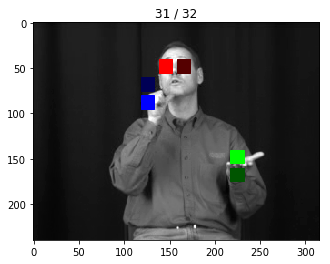

In [47]:
            
batches=2

for batch in range(batches):
    xb,yb=test_iterator.next()
    predictions = model.predict(xb)
    body_parts_coordinates_predicted=localization_target.predictions_to_body_parts_coordinates(predictions,input_shape[0:2])
    body_parts_coordinates_true=localization_target.predictions_to_body_parts_coordinates(yb,input_shape[0:2])
    
    
    batch_size=xb.shape[0]
    for image_index in range(batch_size):
#     image_index+=1 % batch_size
#     image_index=image_index % batch_size
    #print(xb.shape, " ->", )
        plt.imshow(xb[image_index,:,:,0])
        plt.title("%d / %d" % (image_index,batch_size))
        ax=plt.gca()
        draw_coordinates(image_index,body_parts_coordinates_true,body_parts_coordinates_predicted,ax=ax)
            
        plt.show()

In [46]:
plt.close("all")
plt.tight_layout()
i=0
plt.figure()
batches=test_iterator.n // batch_size
while i<4:#batches:
    xb,yb=test_iterator.next()
    predictions = model.predict(xb)
    body_parts_coordinates_predicted=localization_target.predictions_to_body_parts_coordinates(predictions,input_shape[0:2])
    body_parts_coordinates_true=localization_target.predictions_to_body_parts_coordinates(yb,input_shape[0:2])
    
    batch_size=xb.shape[0]
    f,axes = plt.subplots(8, 8,figsize=(20,10))
    for image_index in range(batch_size):
        subplot_i=image_index // 8
        subplot_j= image_index % 8
        ax=axes[subplot_i,subplot_j]
        ax.imshow(xb[image_index,:,:,0])
        draw_coordinates(image_index,body_parts_coordinates_true,body_parts_coordinates_predicted,ax=ax)
        ax.axis('off')
    plt.savefig("tmp/output/%06d.png" % i, bbox_inches='tight',dpi=200)
#     plt.show()

    plt.close()
    i=i+1

